In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib as mpl

from os.path import join

plt.style.use(["seaborn", "thesis"])

# Gaussian

In [2]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    AtomicNumberWeighted, Gaussians
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, RADIAL_GAUSSIAN_MODELS, AZIMUTHAL_GAUSSIAN_MODELS, POLAR_GAUSSIAN_MODELS
    
radial_gaussians = Gaussians(*RADIAL_GAUSSIAN_MODELS["Equidistant-Broadening_1"])
    
descriptor = AtomicNumberWeighted(
    radial_gaussians,
    Gaussians(*AZIMUTHAL_GAUSSIAN_MODELS["Equisitant_1"]),
    Gaussians(*POLAR_GAUSSIAN_MODELS["Equisitant_1"])
)


def make_descriptor(molecule, atom_ind):
    
    return descriptor.calculate_atom_descriptor(
        atom_ind, 
        molecule,
        descriptor.number_of_descriptors
    )

# Display Gaussians

In [3]:
from SCFInitialGuess.descriptors.coordinate_descriptors import behler_cutoff_1

def evaluate_gaussian(x, r_s, eta, R_c):
    return np.exp(-1 * eta*(x - r_s)**2) *  behler_cutoff_1(x, R_c)

def calculate_inverse_descriptor(descriptor_values, centers, widths, R_c, t=None):
    
    if t is None:
        t = np.linspace(0, R_c, 100)
    
    ret = 0
    for v, c, w in zip(descriptor_values, centers, widths):
        ret += v * evaluate_gaussian(t, c, w, R_c)
    return ret

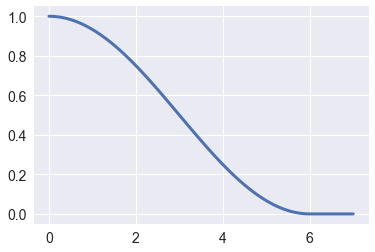

In [4]:
x = np.linspace(0, 7, 100)
plt.plot(x, behler_cutoff_1(x, 6))

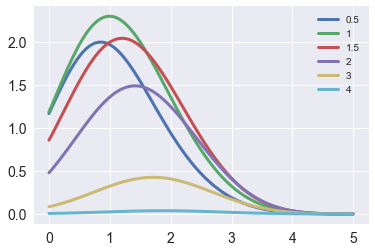

In [5]:
x = np.linspace(0, radial_gaussians.R_c, 100)

for i in [0.5, 1, 1.5, 2, 3, 4]:
    plt.plot(x, calculate_inverse_descriptor(
        radial_gaussians.calculate_descriptor(i), ## for every value placed here, the peak should be the same
        radial_gaussians.r_s,
        radial_gaussians.eta,
        radial_gaussians.R_c
    ),
    label=str(i)
    )
plt.legend()
plt.show()

Klar sichtbar: peaks sind viel zu breit!!!! und positionen können ganz klar, NICHT aufgelöst werden!!

# New Gaussians

In [6]:
def plot_model(model):
    R_c, mus, sigmas = model
    t = np.linspace(0, R_c, 100)
    
    for r_s, eta in zip(mus, sigmas):
        plt.plot(t, evaluate_gaussian(t, r_s, eta, R_c))

In [190]:
def plot_angular_model(model):
    t = np.linspace(-np.pi, 2*np.pi, 500)
    for r_s, eta in zip(model[1], model[2]):
        plt.plot(t, np.exp(-1 * eta*(t - r_s)**2))

## Forward

In [7]:
mymodel = (
    5,
    [0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2, 3.6, 4.0],
    [3.0, 2.5, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.8, 1.5]
)

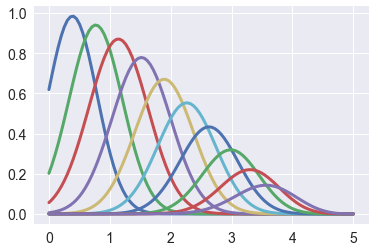

In [9]:
plot_model(mymodel)

## Backprop

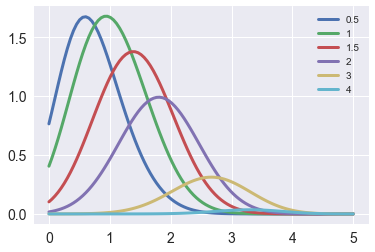

In [10]:
x = np.linspace(0, radial_gaussians.R_c, 100)

model_descriptor = Gaussians(*mymodel)

for i in [0.5, 1, 1.5, 2, 3, 4]:
    plt.plot(x, calculate_inverse_descriptor(
        model_descriptor.calculate_descriptor(i), ## for every value placed here, the peak should be the same
        model_descriptor.r_s,
        model_descriptor.eta,
        model_descriptor.R_c,
        t=x
    ),
    label=str(i)
    )
plt.legend()
plt.show()

In [ ]:
x = np.linspace(0, 2.2, 100)

model_descriptor = Gaussians(*mymodel)

for i in [0.5, 0.7, 0.9, 1.0, 1.2, 1.4, 1.8]:
    plt.plot(x, calculate_inverse_descriptor(
        model_descriptor.calculate_descriptor(i), ## for every value placed here, the peak should be the same
        model_descriptor.r_s,
        model_descriptor.eta,
        model_descriptor.R_c, 
        t=x
    ),
    label=str(i)
    )
plt.legend()
plt.show()

# Designing Gaussians

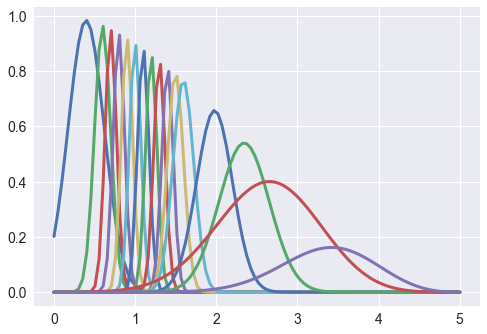

In [193]:
radial_model = (
    5,
    [ 0.4, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 2.0, 2.4, 3.0, 4.0],
    [ 10, 50, 100, 100, 100, 100, 100, 100, 100, 100, 50., 30., 10., 5.0, 1.0, 1.0]
)
plot_model(radial_model)

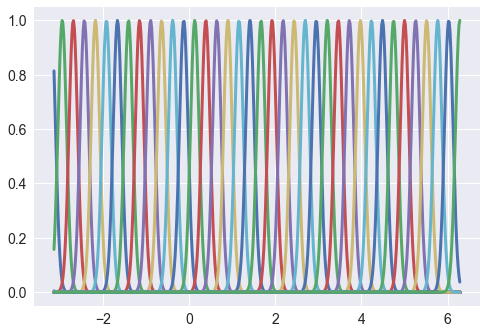

In [213]:
azimutahl_model = (
    5,
    np.linspace(-2 * np.pi, 2 * np.pi, 50),
    [50] * 50
)
plot_angular_model(azimutahl_model)

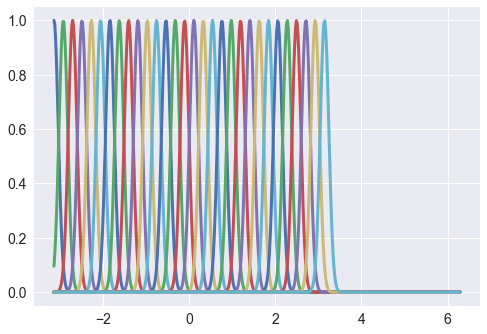

In [214]:
polar_model = (
    5,
    np.linspace(-np.pi, np.pi, 30),
    [50] * 30
)
plot_angular_model(polar_model)

Fazit: diese vielen Gaussians ergeben jetzt halbwegs an den punten ein maximum an dem eine Erregung abgetastet wurde

# Anregungs surf

Im punkt r= 2 phi = 2 wird eine anregung hinein gesetzet. Mal schauen ob die das Reproduzieren können.

In [215]:
r = np.linspace(0, 5, 20)
phi = np.linspace(- np.pi, np.pi, 20)

R, Phi = np.meshgrid(r, phi)

In [168]:
def activation(r, phi, values_radial, radial_model, values_angular, angular_model):
    
    ret_radial = 0
    for v_rad, r_s_rad, eta_rad in zip(values_radial, radial_model[1], radial_model[2]):
        ret_radial += v_rad * evaluate_gaussian(r, r_s_rad, eta_rad, radial_model[0]) 
    
    ret_ang = 0
    for v_ang, r_s_ang, eta_ang in zip(values_angular, angular_model[1], [angular_model[2]]*len(angular_model[1])):
        ret_ang += v_ang * evaluate_gaussian(phi, r_s_ang, eta_ang, angular_model[0])

    return ret_radial * ret_ang

In [169]:
mymodel = radial_model

In [200]:
# anregung bei r=3 und r= 0.8
radial_value = np.array(model_descriptor.calculate_descriptor(2)) + \
    0.5 * np.array(model_descriptor.calculate_descriptor(1)) + \
    15.0 * np.array(model_descriptor.calculate_descriptor(4))
    
# anregung bei phi = 2
angular_value = Gaussians(*POLAR_GAUSSIAN_MODELS["Equisitant_1"]).calculate_descriptor(2)

In [201]:
z = activation(
    R, 
    Phi,
    radial_value,
    mymodel,
    angular_value,
    POLAR_GAUSSIAN_MODELS["Equisitant_1"]
)

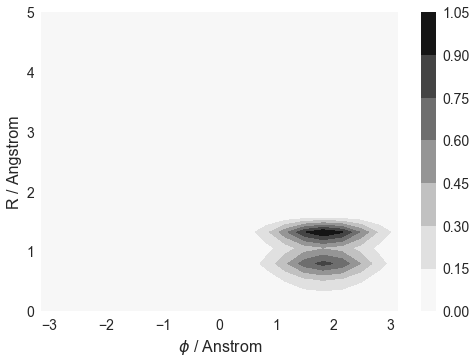

In [202]:
plt.contourf(Phi, R, z)
plt.ylabel("R / Angstrom")
plt.xlabel("$\phi$ / Anstrom")
plt.colorbar()

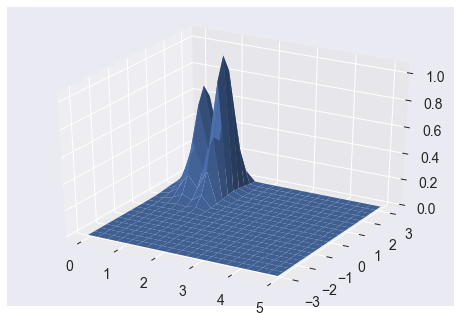

In [173]:
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(R, Phi, z)
plt.show()

TODOs:
Mehrer ANregungne müssen separat erkennbar sein (zumindest muss es da ein bisschen anregung geben!!!

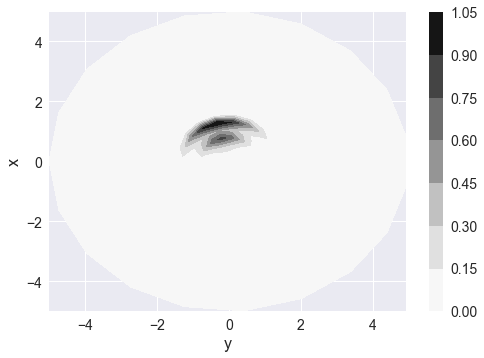

In [174]:
plt.contourf(R * np.cos(Phi), R * np.sin(Phi), z)
plt.ylabel("x")
plt.xlabel("y")
plt.colorbar()

# A Molecule

In [216]:
from SCFInitialGuess.utilities.dataset import Molecule

angle_HCC = 121.3/180 *np.pi
distance_CC = 1.339
distance_CH = 1.087

mol = Molecule(
    species=["C", "C", "H", "H", "H", "H"],
    positions=[
        [ 0.00000,       0.00000,        0.00000],
        [ distance_CC  ,       0.00000,        0.00000],
        [ distance_CH * np.cos(angle_HCC), distance_CH * np.sin(angle_HCC), 0.00000],
        [ distance_CH * np.cos(2*np.pi - angle_HCC), distance_CH * np.sin(2*np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(np.pi - angle_HCC), distance_CH * np.sin(np.pi - angle_HCC), 0.00000],
        [ distance_CC + distance_CH * np.cos(- np.pi + angle_HCC), distance_CH * np.sin(- np.pi + angle_HCC), 0.00000]
    ]
)

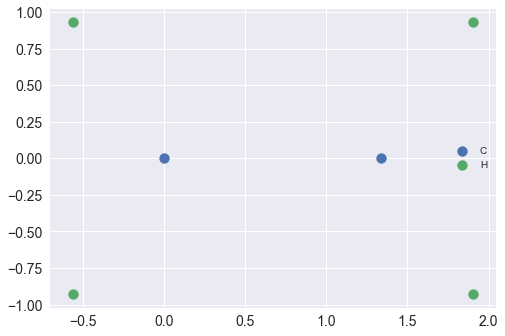

In [217]:
pos = np.array(mol.positions)
plt.scatter(pos[:2, 0], pos[:2, 1], label="C")
plt.scatter(pos[2:, 0], pos[2:, 1], label="H")
plt.legend()

## Calculate descriptor for first C


## AtomicNumberWeighted

In [218]:
from SCFInitialGuess.descriptors.coordinate_descriptors import NonWeighted, AtomicNumberWeighted

descriptor = AtomicNumberWeighted(
    Gaussians(*radial_model),
    Gaussians(*azimutahl_model),
    Gaussians(*polar_model)
)

descriptor_val_mol = descriptor.calculate_atom_descriptor(
    1, 
    mol,
    descriptor.number_of_descriptors
)

In [219]:
radial_values = descriptor_val_mol[:descriptor.radial_descriptor.number_of_descriptors]
azimuthal_values = descriptor_val_mol[descriptor.radial_descriptor.number_of_descriptors:(descriptor.radial_descriptor.number_of_descriptors + descriptor.azimuthal_descriptor.number_of_descriptors)]
polar_values = descriptor_val_mol[descriptor.radial_descriptor.number_of_descriptors + descriptor.azimuthal_descriptor.number_of_descriptors:]

### 1D Curves

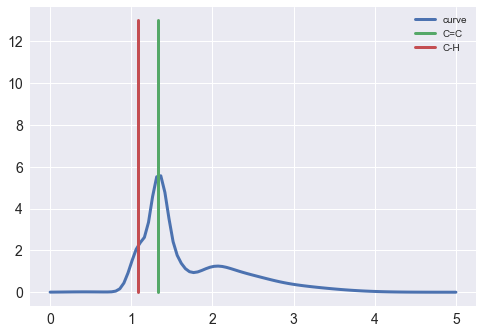

In [220]:
x = np.linspace(0, mymodel[0], 100)
plt.plot(x, calculate_inverse_descriptor(
    radial_values, ## for every value placed here, the peak should be the same
    radial_model[1],
    radial_model[2],
    radial_model[0], 
    t=x
), label="curve")
plt.plot([1.33] * 2, [0, 13], label="C=C")
plt.plot([1.087] * 2, [0, 13], label="C-H")
plt.legend()

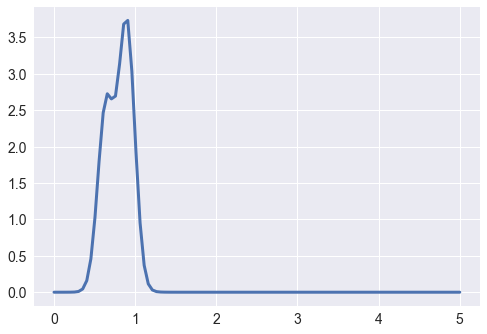

In [221]:
x = np.linspace(0, mymodel[0], 100)
plt.plot(x, calculate_inverse_descriptor(
    azimuthal_values, ## for every value placed here, the peak should be the same
    azimutahl_model[1],
    azimutahl_model[2],
    azimutahl_model[0], 
    t=x
), label="Gaussian")
#plt.plot([np.pi/3]*2, [0, 12], label="HCC")

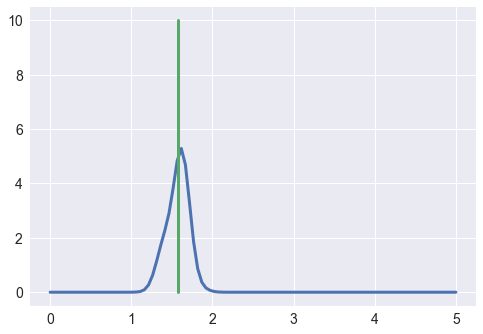

In [222]:
x = np.linspace(0, mymodel[0], 100)
plt.plot(x, calculate_inverse_descriptor(
    polar_values, ## for every value placed here, the peak should be the same
    polar_model[1],
    polar_model[2],
    polar_model[0], 
    t=x
))
plt.plot([np.pi / 2]*2, [0, 10])

### 2 D Contures

In [223]:
z = activation(
    R, 
    Phi,
    radial_values,
    mymodel,
    azimuthal_values,
    AZIMUTHAL_GAUSSIAN_MODELS["Equisitant_1"]
)

/home/jo/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


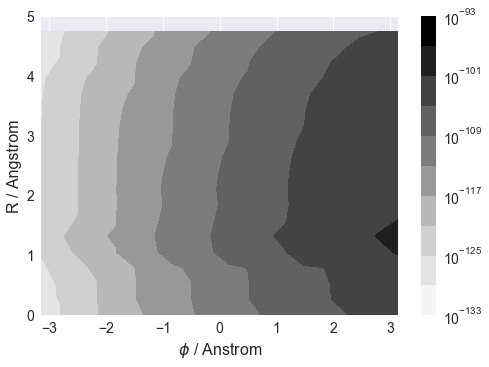

In [224]:
plt.contourf(Phi, R, z, locator=mpl.ticker.LogLocator())
plt.ylabel("R / Angstrom")
plt.xlabel("$\phi$ / Anstrom")
plt.colorbar()

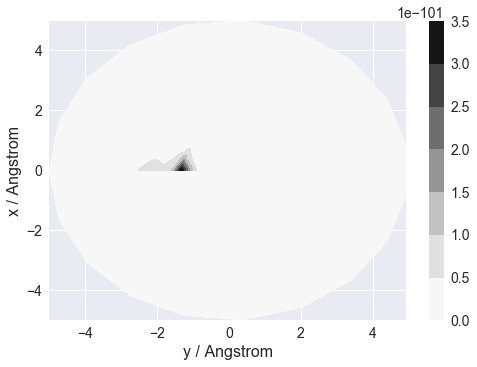

In [225]:
plt.contourf(
    R * np.cos(Phi), 
    R * np.sin(Phi), 
    z, 
    #locator=mpl.ticker.LogLocator()
)

plt.ylabel("x / Angstrom")
plt.xlabel("y / Angstrom")
plt.colorbar()

 # TODO
 Angular part muss gefixt werden!
 Modularität nicht erfüllt. für +pi und - pi muss das gleich herauskommen!